In [134]:
import scipy.io

import sys
realmin = sys.float_info.min

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import copy
import random
import math
from statistics import NormalDist
import scipy
import time

from scipy.optimize import minimize
from numba import jit, njit

In [135]:
# from google.colab import drive
# drive.mount('/content/drive')

# group = "senate"
# filename = f"/content/drive/My Drive/KPI/KPI навчання/5-6 курс/Дипломне проектування/Article replication/Data/processed data_{group}.mat"

# dataframe_mat = scipy.io.loadmat(filename)

In [136]:
group = "senate"
dataframe_mat = scipy.io.loadmat(f"Data/data_{group}.mat")

In [137]:
vote_rc = pd.DataFrame(
    data = dataframe_mat['V_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['V_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['V_rc'][0]))] # 1st row as the column names
)
vote_rc = vote_rc.replace({-100: np.nan, -1: 0, 1: 1})

party_leadership_position_rc = pd.DataFrame(
    data = dataframe_mat['party_leadership_position_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['party_leadership_position_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['party_leadership_position_rc'][0]))] # 1st row as the column names
)
party_list = pd.DataFrame(
    data = dataframe_mat['party_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['party_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['party_list'][0]))] # 1st row as the column names
)
congress_list = pd.DataFrame(
    data = dataframe_mat['congress_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['congress_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['congress_list'][0]))] # 1st row as the column names
)

### 1. Data Preproccessing

In [138]:
print(f"{group.upper()} statistics")
print("----------------")

congress_id, bills_per_congress = np.unique(congress_list.values, return_counts=True)
print(f"\nNumber of bills overall = {np.sum(bills_per_congress)} ({len(congress_id)} congresses, id: {np.min(congress_id)} - {np.max(congress_id)})")
print(f"Number of deputies overall = {party_list.size}")

all_dataset = False

if all_dataset == False:
	congress_id_involved = 70
	print(f"\nCongress id involved: {congress_id_involved}")

	beginning_bills_in_congresses_involved = bills_per_congress[
		0:int(congress_id_involved - np.min(congress_id))
	].sum()
	ending_bills_in_congresses_involved = bills_per_congress[
		0:int(congress_id_involved - np.min(congress_id) + 1)
	].sum()

	vote_congress = vote_rc.iloc[:,beginning_bills_in_congresses_involved:ending_bills_in_congresses_involved].dropna(how='all')
	vote_congress_array = np.array(vote_congress)

	party_list_congress = party_list.loc[vote_congress.index]
	party_list_congress_array = np.array(party_list_congress).flatten()

	party_leadership_position_rc_congress = party_leadership_position_rc
	party_leadership_position_rc_congress_array = np.array(party_leadership_position_rc_congress)

	N = vote_congress.shape[0]
	T = vote_congress.shape[1]

	print(f"Number of bills in the congress = {T}")
	print(f"Number of deputies in the congress = {N}")
else:
	vote_congress = vote_rc
	vote_congress_array = np.array(vote_congress)

	party_list_congress = party_list
	party_list_congress_array = np.array(party_list_congress).flatten()

	party_leadership_position_rc_congress = party_leadership_position_rc
	party_leadership_position_rc_congress_array = np.array(party_leadership_position_rc_congress)

	N = vote_congress.shape[0]
	T = vote_congress.shape[1]

	print(f"\nNumber of bills = {T}")
	print(f"Number of deputies = {N}")

SENATE statistics
----------------

Number of bills overall = 25824 (46 congresses, id: 70 - 115)
Number of deputies overall = 789

Congress id involved: 70
Number of bills in the congress = 191
Number of deputies in the congress = 98


In [139]:
vote_congress

,1,2,3,4,5,6,7,8,9,10,...,182,183,184,185,186,187,188,189,190,191
7,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,NaN,1.0,NaN,0.0,1.0,0.0,NaN
16,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
20,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
29,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
30,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,NaN
402,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
404,1.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
407,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,NaN


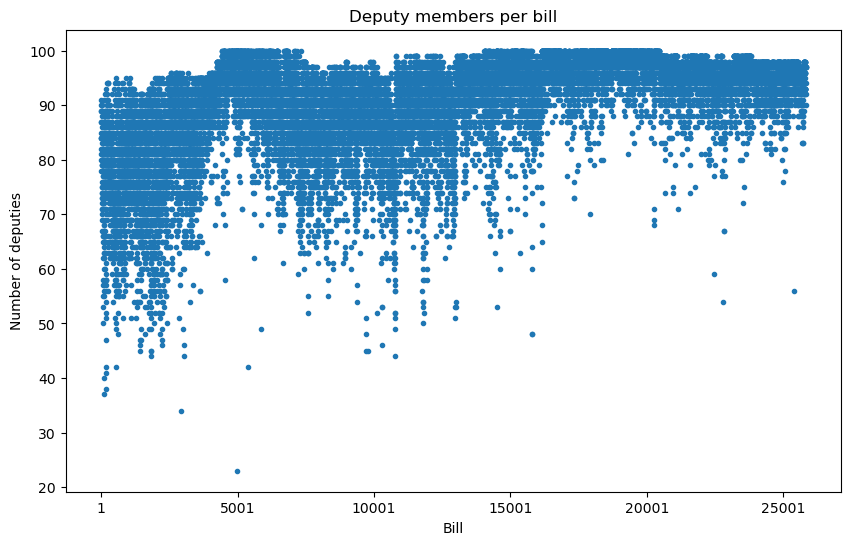

In [140]:
plt.figure(figsize=(10,6))
vote_rc.notna().sum().plot(title="Deputy members per bill", style=".", xlabel="Bill", ylabel="Number of deputies")
plt.show()

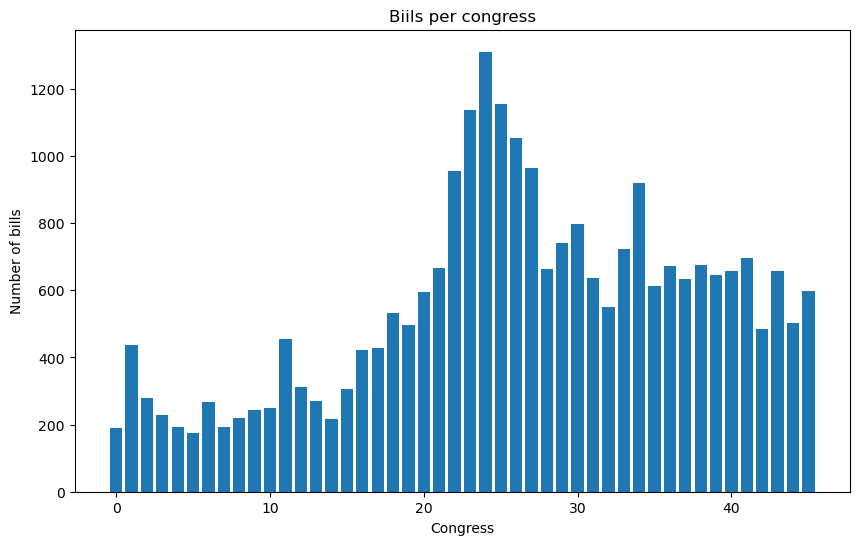

In [141]:
plt.figure(figsize=(10,6))
plt.bar(x=np.arange(0,len(bills_per_congress)), height=bills_per_congress)
plt.xlabel("Congress")
plt.ylabel("Number of bills")
plt.title("Biils per congress")
plt.show()

In [142]:
party_direction_congress_array = copy.deepcopy(party_leadership_position_rc_congress_array)

### 2. Initial Guess

In [143]:
random.seed(112)

theta = np.array([random.uniform(0,1) for _ in range(N)])

# Normalize theta
theta = theta - theta[0]

if party_list_congress_array[0] == 100:
	# center Dems around 0 and GOP further right
	theta[1:] = [
		theta[i] - 0.5 if party_list_congress_array[i] == 100 else theta[i] + 0.5 
		for i in range(1,len(theta))
	]
else:
	# center GOP around 0 and Dems further left
	theta[1:] = [
		theta[i] - 1.5 if party_list_congress_array[i] == 100 else theta[i] - 0.5 
		for i in range(1,len(theta))
	]

# initialize ymax
ymax = np.array([random.uniform(0,1), random.uniform(0,1)])

# initialize cutlines for bills
m = np.array([1 - 2*random.uniform(0,1) for _ in range(T)])

# construct a big parameter vector
omega_initial_guess = np.concatenate([theta, ymax, m])

print(f"Parameters of the model: {len(omega_initial_guess)}")

Parameters of the model: 291


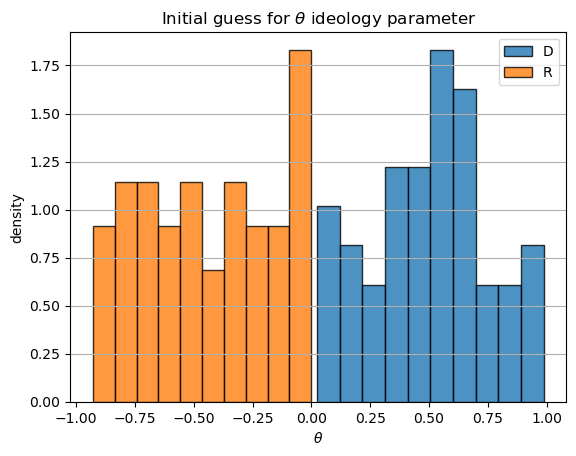

In [144]:
R_omega_initial_guess = [omega_initial_guess[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100]
D_omega_initial_guess = [omega_initial_guess[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200]

plt.hist(D_omega_initial_guess, density=True, label='D', alpha=0.8, edgecolor='black')
plt.hist(R_omega_initial_guess, density=True, label='R', alpha=0.8, edgecolor='black')
plt.legend()

plt.grid(axis='y')
plt.xlabel(r"$\theta$")
plt.ylabel(r"density")
plt.title(r"Initial guess for $\theta$ ideology parameter")
plt.show()

### 3. Likelihood Optimization

In [145]:
@njit
def norm_cdf(x):
    # Cumulative distribution function for the standard normal distribution
    return (1.0 + math.erf(x / np.sqrt(2.0))) / 2.0

In [146]:
@njit
def norm_sf(x):
    # (1 - cdf) for the standard normal distribution
    return math.erfc(x / np.sqrt(2.0)) / 2.0

In [147]:
@njit
def neg_likelihood(omega):
	# Unpack (decompose) parameter vector
	theta = np.zeros(N)
	ymax = np.zeros(2)
	m = np.zeros(T)

	for deputy in range(N):
		theta[deputy] = omega[deputy]

	ymax[0], ymax[1] = omega[0 + N], omega[1 + N]

	for bill in range(T):
		m[bill] = omega[N + 2 + bill]
  
	# Calculate likelihood value
	likelihood_value = 0

	for bill in range(T):
		for deputy in np.where(~np.isnan(vote_congress_array.T[bill]))[0]:			
			party_id = int(bool(party_list_congress_array[deputy] - 100)) # R for 1 (200), D for 0 (100)
			
			if party_direction_congress_array[deputy][bill] == 1.0:
				whip_party_pos = 1.0
				whip_party_neg = -1.0
			if party_direction_congress_array[deputy][bill] == -1.0:
				whip_party_pos = -1.0
				whip_party_neg = 1.0

			cdf_arg_pos = (
				m[bill] - theta[deputy] - whip_party_pos*ymax[party_id]
			)

			cdf_arg_neg = (
				m[bill] - theta[deputy] - whip_party_neg*ymax[party_id]
			)

			# math.erf()
			cdf_value_arg_pos = norm_cdf(cdf_arg_pos)
			sf_value_arg_pos = norm_sf(cdf_arg_pos)

			cdf_value_arg_neg = norm_cdf(cdf_arg_neg)
			sf_value_arg_neg = norm_sf(cdf_arg_neg)

			indicator = cdf_value_arg_pos == 0
			cdf_value_arg_pos = indicator*realmin + (1-indicator)*cdf_value_arg_pos
			logcdf_value_arg_pos = np.log(cdf_value_arg_pos)

			indicator = sf_value_arg_pos == 0
			sf_value_arg_pos = indicator*realmin + (1-indicator)*sf_value_arg_pos
			logsf_value_arg_pos = np.log(sf_value_arg_pos)

			indicator = cdf_value_arg_neg == 0
			cdf_value_arg_neg = indicator*realmin + (1-indicator)*cdf_value_arg_neg
			logcdf_value_arg_neg = np.log(cdf_value_arg_neg)

			indicator = sf_value_arg_neg == 0
			sf_value_arg_neg = indicator*realmin + (1-indicator)*sf_value_arg_neg
			logsf_value_arg_neg = np.log(sf_value_arg_neg)

			# scipy.stats.norm()
			# logcdf_value_arg_pos = scipy.stats.norm.logcdf(cdf_arg_pos)
			# logsf_value_arg_pos = scipy.stats.norm.logsf(cdf_arg_pos)

			# logcdf_value_arg_neg = scipy.stats.norm.logcdf(cdf_arg_neg)
			# logsf_value_arg_neg = scipy.stats.norm.logsf(cdf_arg_neg)

			likelihood_pos = vote_congress_array[deputy][bill] * logcdf_value_arg_pos + \
				(1 - vote_congress_array[deputy][bill]) * logsf_value_arg_pos
			likelihood_neg = vote_congress_array[deputy][bill] * logsf_value_arg_neg + \
				(1 - vote_congress_array[deputy][bill]) * logcdf_value_arg_neg

			likelihood_value += max(likelihood_pos,likelihood_neg)

	return -likelihood_value

In [148]:
neg_likelihood(omega_initial_guess)

start_time = time.time()
print(f"log(L) = {neg_likelihood(omega_initial_guess)}")
end_time = time.time()
print(f"Time of one execution = {round(end_time-start_time,4)} s")

log(L) = 5113.998613126294
Time of one execution = 0.0012 s


In [149]:
result = minimize(
	fun = neg_likelihood,
	x0 = omega_initial_guess,
	method = "SLSQP", # "SLSQP", "Nelder-Mead"
    # jac = jacobian,
    options = {"maxiter": 1000}
)

In [150]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 9.872832424894263e-05
       x: [ 2.512e+01  7.987e+00 ... -2.721e+00 -1.697e+01]
     nit: 101
     jac: [ 8.941e-08  0.000e+00 ... -1.490e-08  0.000e+00]
    nfev: 29512
    njev: 101

Distance between party centroids = 35.2702


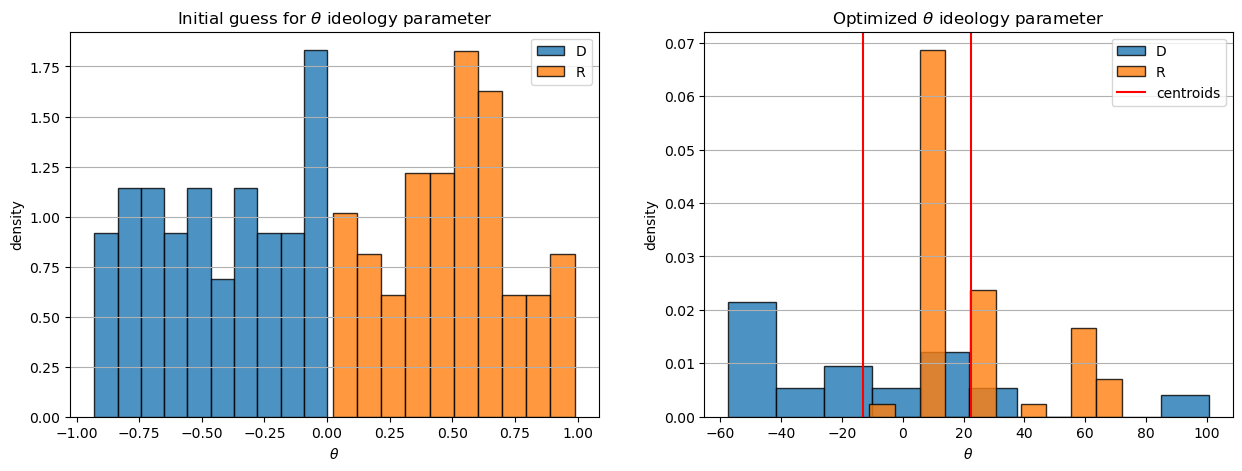

In [151]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(
    [omega_initial_guess[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100],
    density=True, label='D', alpha=0.8, edgecolor='black'
)
plt.hist(
    [omega_initial_guess[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200],
    density=True, label='R', alpha=0.8, edgecolor='black'
)
plt.legend()

plt.grid(axis='y')
plt.xlabel(r"$\theta$")
plt.ylabel(r"density")
plt.title(r"Initial guess for $\theta$ ideology parameter")

omega_hat = result.x
theta_R = [omega_hat[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100]
R_party_centroid = np.mean(theta_R)

theta_D = [omega_hat[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200]
D_party_centroid = np.mean(theta_D)

distance_between_party_centroids = np.abs(R_party_centroid - D_party_centroid)
print(f"Distance between party centroids = {round(distance_between_party_centroids, 4)}")

plt.subplot(1,2,2)
plt.hist(
    [omega_hat[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100],
    density=True, label='D', alpha=0.8, edgecolor='black'
)
plt.hist(
    [omega_hat[deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200],
    density=True, label='R', alpha=0.8, edgecolor='black'
)

plt.axvline(R_party_centroid, color="red", label="centroids")
plt.axvline(D_party_centroid, color="red")

plt.legend()
plt.grid(axis='y')
plt.xlabel(r"$\theta$")
plt.ylabel(r"density")
plt.title(r"Optimized $\theta$ ideology parameter")

plt.show()